# CS246 - Colab 2
## Frequent Pattern Mining in Spark

In [115]:
from IPython.display import Image
print("Colab 2 Mascot")
Image(url='https://cdn.dribbble.com/users/222579/screenshots/1654898/stubby-ben-rex-roll.gif',width=150)

Colab 2 Mascot


### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [116]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u372-ga~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [118]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [119]:
id='1dhi1F78ssqR8gE6U-AgB80ZW7V_9snX4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('products.csv')

id='1KZBNEaIyMTcsRV817us6uLZgm-Mii8oU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('order_products__train.csv')

If you executed the cells above, you should be able to see the dataset we will need for this Colab under the "Files" tab on the left panel.

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [124]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

ValueError: ignored

### Your task

If you run successfully the setup stage, you are ready to work with the **3 Million Instacart Orders** dataset. In case you want to read more about it, check the [official Instacart blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) about it, a concise [schema description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) of the dataset, and the [download page](https://www.instacart.com/datasets/grocery-shopping-2017).

In this Colab, we will be working only with a small training dataset (~131K orders) to perform fast Frequent Pattern Mining with the FP-Growth algorithm.

In [125]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [126]:
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [127]:
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)



Use the Spark Dataframe API to join 'products' and 'orders', so that you will be able to see the product names in each transaction (and not only their ids).  Then, group by the orders by 'order_id' to obtain one row per basket (i.e., set of products purchased together by one customer).

In [128]:
''' 2 lines of code expected '''
# YOUR CODE HERE
product_joined = products.join(orders, products.product_id == orders.product_id)
customer_purchased = product_joined.groupBy('order_id').agg(collect_list('product_name').alias('purchased_item'))
customer_purchased.show()

+--------+--------------------+
|order_id|      purchased_item|
+--------+--------------------+
|       1|[Bulgarian Yogurt...|
|      96|[Roasted Turkey, ...|
|     112|[Fresh Cauliflowe...|
|     218|[Natural Artisan ...|
|     456|[Chorizo Pork, Pe...|
|     473|[Organic Whole Mi...|
|     631|[Organic Strawber...|
|     762|[Organic Strawber...|
|     774|[Ice Cream Variet...|
|     844|[Green Beans, Org...|
|     904|[Cup Noodles Chic...|
|     988|[Natural Vanilla ...|
|    1032|[Clover Org Greek...|
|    1077|[Bag of Organic B...|
|    1119|[Boneless Skinles...|
|    1139|[Banana, Organic ...|
|    1143|[Natural Premium ...|
|    1145|[Banana, Original...|
|    1275|[Boneless Skinles...|
|    1280|[Lactose Free Hal...|
+--------+--------------------+
only showing top 20 rows



In this Colab we will explore [MLlib](https://spark.apache.org/mllib/), Apache Spark's scalable machine learning library. Specifically, you can use its implementation of the [FP-Growth](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html#fp-growth) algorithm to perform efficiently Frequent Pattern Mining in Spark.
Use the Python example in the documentation, and train a model with

```minSupport=0.01``` and ```minConfidence=0.5```



In [146]:
''' 3 lines of code expected '''
# YOUR CODE HERE
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol= "purchased_item", minSupport= 0.01, minConfidence= 0.5)
model = fpGrowth.fit(customer_purchased)
model.freqItemsets.show()

+--------------------+-----+
|               items| freq|
+--------------------+-----+
|      [Green Onions]| 1445|
|   [Red Raspberries]| 1493|
|    [Organic Banana]| 2332|
|  [Jalapeno Peppers]| 1899|
|[Organic Large Ex...| 2891|
|[Organic Whole St...| 1993|
|[Organic Peeled W...| 2460|
|             [Limes]| 6033|
|[Limes, Large Lemon]| 1595|
|     [Limes, Banana]| 1331|
|       [Raspberries]| 3279|
|      [Hass Avocado]| 1633|
|[Organic Broccoli...| 1361|
|[Uncured Genoa Sa...| 1788|
|      [Spring Water]| 2225|
|[Michigan Organic...| 2627|
|     [Yellow Onions]| 3762|
|[Organic Strawber...|10894|
|[Organic Strawber...| 3074|
|[Organic Strawber...| 2174|
+--------------------+-----+
only showing top 20 rows



Compute how many frequent itemsets and association rules were generated by running FP-growth alongside visalizing top frequent itemsets and association rules.


In [147]:
''' 5 lines of code in total expected but can differ based on your style. for sub-parts of the question, creating different cells of code would be recommended.'''
# YOUR CODE HERE
model.associationRules.show()

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



In [148]:
freq_item = model.freqItemsets
ass_item = model.associationRules
print('Number of frequent itemsets:', freq_item.count(), '\nNumber of asscociated rule:', ass_item.count())

Number of frequent itemsets: 120 
Number of asscociated rule: 0


In [149]:
sorted_freq_item = freq_item.sort(freq_item.freq.desc()).toPandas()
sorted_freq_item.head()

,items,freq
0,[Banana],18726
1,[Bag of Organic Bananas],15480
2,[Organic Strawberries],10894
3,[Organic Baby Spinach],9784
4,[Large Lemon],8135


Text(0.5, 1.0, 'Item Frequents')

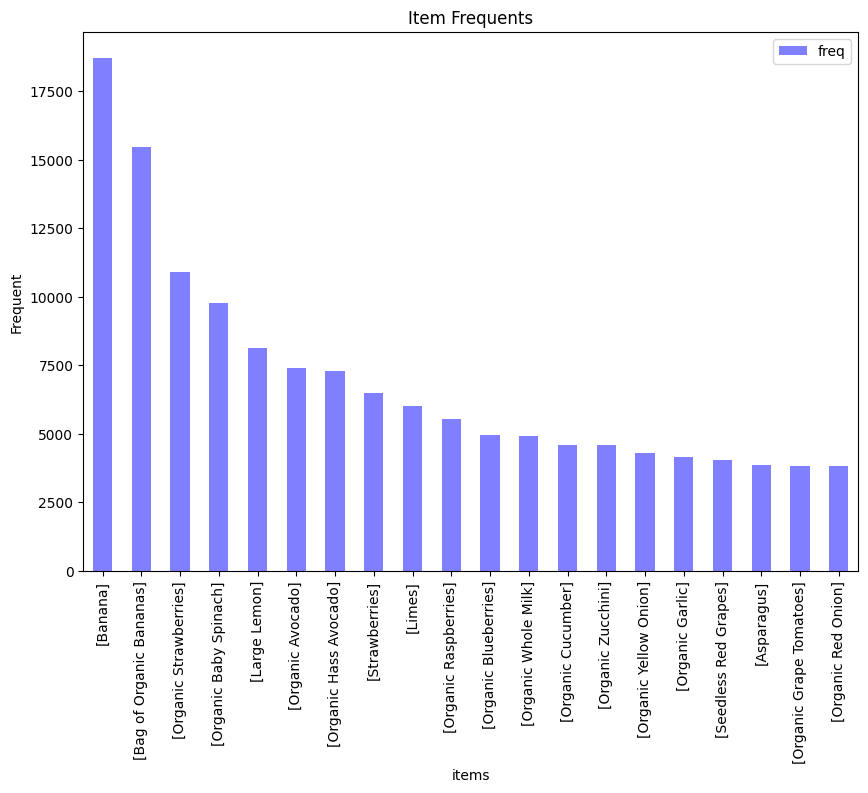

In [150]:
''' 5 lines of code in total expected but can differ based on your style. for sub-parts of the question, creating different cells of code would be recommended.'''
# YOUR CODE HERE
pl = sorted_freq_item.head(20).plot(kind= 'bar', x= 'items', y= 'freq', figsize= (10,7), log= False, alpha= 0.5, color= 'blue')
pl.set_xlabel("items")
pl.set_ylabel("Frequent")
pl.set_title("Item Frequents")

Now retrain the FP-growth model changing only
```minsupport=0.001```
and compute how many frequent itemsets and association rules were generated.


In [152]:
# YOUR CODE HERE
fpGrowth2 = FPGrowth(itemsCol= "purchased_item", minSupport= 0.001, minConfidence= 0.5)
model2 = fpGrowth2.fit(customer_purchased)
freq_item2 = model2.freqItemsets
ass_item2 = model2.associationRules
print('Number of frequent itemsets:', freq_item2.count(), '\nNumber of asscociated rule:', ass_item2.count())

Number of frequent itemsets: 4444 
Number of asscociated rule: 11


To conclude, go to Gradescope and read the remaining questions. We will ask you to inspect the resulting dataframes, and report a few results.



Once you obtained the desired results, **head over to Gradescope and submit your solution for this Colab**!